<a href="https://colab.research.google.com/github/szuchiali/Stock-Prediction-with-daily-news-headlines/blob/main/Stock_Price_Prediction_with_daily_News_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchtext==0.4.0

import numpy as np 
import pandas as pd
import re
import os
import sys
import math
import nltk
import torch
import random
import string
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import functional as F
from torch.autograd import Variable

nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Machine Learning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Combined_News_DJIA.csv')

In [ ]:
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']
print(train.shape)
print(test.shape)

(1863, 27)
(378, 27)


In [ ]:
#extract only the top 25 titles
dataset = train.iloc[:, 2:27]
# replace characters except alphabet with blank 
dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

In [ ]:
#convert all headlines to lower cases
dataset.columns = [str(i) for i in [j for j in range(25)]]
for i in dataset.columns:
    dataset[i] = dataset[i].str.lower()
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,b rice gives green light for israel to attack ...,b announcing class action lawsuit on behalf of...,b so russia and georgia are at war and the n...,b china tells bush to stay out of other countr...,b did world war iii start today,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge
1,b why wont america and nato help us if they w...,b bush puts foot down on georgian conflict,b jewish georgian minister thanks to israeli ...,b georgian army flees in disarray as russians ...,b olympic opening ceremony fireworks faked,b what were the mossad with fraudulent new zea...,b russia angered by israeli military sale to g...,b an american citizen living in s ossetia blam...,b welcome to world war iv now in high definit...,b georgia s move a mistake of monumental prop...,b russia presses deeper into georgia u s say...,b abhinav bindra wins first ever individual ol...,b u s ship heads for arctic to define territ...,b drivers in a jerusalem taxi station threaten...,b the french team is stunned by phelps and the...,b israel and the us behind the georgian aggres...,b do not believe tv neither russian nor geor...,b riots are still going on in montreal canada...,b china to overtake us as largest manufacturer,b war in south ossetia pics,b israeli physicians group condemns state tort...,b russia has just beaten the united states ov...,b perhaps the question about the georgia r...,b russia is so much better at war,b so this is what it s come to trading sex fo...
2,b remember that adorable year old who sang a...,b russia ends georgia operation,b if we had no sexual harassment we would hav...,b al qa eda is losing support in iraq because ...,b ceasefire in georgia putin outmaneuvers the...,b why microsoft and intel tried to kill the xo...,b stratfor the russo georgian war and the bal...,b i m trying to get a sense of this whole geor...,b the us military was surprised by the timing ...,b u s beats war drum as iran dumps the dollar,b gorbachev georgian military attacked the s...,b cnn use footage of tskhinvali ruins to cover...,b beginning a war as the olympics were opening...,b pyramids as large as the luxor stacked in...,b the top party cities in the world,b u s troops still in georgia did you know t...,b why russias response to georgia was right,b gorbachev accuses u s of making a serious ...,b russia georgia and nato cold war two,b remember that adorable year old who led y...,b war in georgia the israeli connection,b all signs point to the us encouraging georgi...,b christopher king argues that the us and nato...,b america the new mexico,b bbc news asia pacific extinction by man...
3,b u s refuses israel weapons to attack iran ...,b when the president ordered to attack tskhinv...,b israel clears troops who killed reuters cam...,b britain s policy of being tough on drugs is...,b body of year old found in trunk latest ...,b china has moved million quake survivors...,b bush announces operation get all up in russi...,b russian forces sink georgian ships,b the commander of a navy air reconnaissance s...,b of cnn readers russia s ac

In [ ]:
# ' '.join(str(x) for x in dataset.iloc[0, 0:25])  #example

'b georgia  downs two russian warplanes  as countries move to brink of war  b breaking  musharraf to be impeached   b russia today  columns of troops roll into south ossetia  footage from fighting  youtube   b russian tanks are moving towards the capital of south ossetia  which has reportedly been completely destroyed by georgian artillery fire  b afghan children raped with  impunity   u n  official says   this is sick  a three year old was raped and they do nothing  b     russian tanks have entered south ossetia whilst georgia shoots down two russian jets   b breaking  georgia invades south ossetia  russia warned it would intervene on so s side  b the  enemy combatent  trials are nothing but a sham  salim haman has been sentenced to       years  but will be kept longer anyway just because they feel like it   b georgian troops retreat from s  osettain capital  presumably leaving several hundred people killed   video   b did the u s  prep georgia for war with russia   b rice gives green

In [ ]:
# create a list that combines the total 25 headlines together for each instances
totalheads = []
for row in range(0, len(dataset.index)):
    totalheads.append(' '.join(str(j) for j in dataset.iloc[row, 0:25]))
len(totalheads)

1863

In [ ]:
clean = pd.DataFrame(totalheads,columns=['Text'])
clean

,Text
0,b georgia downs two russian warplanes as cou...
1,b why wont america and nato help us if they w...
2,b remember that adorable year old who sang a...
3,b u s refuses israel weapons to attack iran ...
4,b all the experts admit that we should legalis...
...,...
1858,brazil declares emergency after babies a...
1859,germany recruits teachers to teach germa...
1860,pentagon thwarts obama s effort to close guant...
1861,tech companies face criminal charges if they n...


In [ ]:
#use CountVectorizer ngrams of (2, 2) to combine 2 words together and vectorize them
cv = CountVectorizer(ngram_range=(2, 2))
trainingset = cv.fit_transform(totalheads)

In [ ]:
k = trainingset.toarray()

In [ ]:
clean = pd.DataFrame(k)

In [ ]:
clean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,403937,403938,403939,403940,403941,403942,403943,403944,403945,403946,403947,403948,403949,403950,403951,403952,403953,403954,403955,403956,403957,403958,403959,403960,403961,403962,403963,403964,403965,403966,403967,403968,403969,403970,403971,403972,403973,403974,403975,403976
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# The dimension of the result sparse matrix is 25*6240
csr_matrix.get_shape(trainingset)

(1863, 403977)

In [ ]:
# implement random forest classifier to train the model
randomClassifier = RandomForestClassifier(n_estimators=250, criterion='entropy')
randomClassifier.fit(trainingset, train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# **Predict the test set**

test_dataset = test.iloc[:, 2:27]
# replace characters except alphabet with blank 
test_dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

test_dataset.columns = [str(i) for i in [j for j in range(25)]]
for i in test_dataset.columns:
    test_dataset[i] = test_dataset[i].str.lower()

test_totalheads =[]
for i in range(0, len(test_dataset.index)):
    test_totalheads.append(' '.join(str(j) for j in test_dataset.iloc[i, 0:25]))


In [ ]:
testingset = cv.transform(test_totalheads)
test_predictions = randomClassifier.predict(testingset)

In [ ]:
len(test_predictions)

378

In [ ]:
matrix = confusion_matrix(test['Label'], test_predictions)
print(matrix)
score = accuracy_score(test['Label'], test_predictions)
print(score)
report = classification_report(test['Label'], test_predictions)
print(report)

[[131  55]
 [  2 190]]
0.8492063492063492
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       186
           1       0.78      0.99      0.87       192

    accuracy                           0.85       378
   macro avg       0.88      0.85      0.85       378
weighted avg       0.88      0.85      0.85       378



In [ ]:
tfidf_v = TfidfVectorizer(ngram_range=(2, 2))

tfidf_trainingset = tfidf_v.fit_transform(totalheads)

tftdf_randomClassifier = RandomForestClassifier(n_estimators=250, criterion='entropy')
tftdf_randomClassifier.fit(tfidf_trainingset, train['Label'])

tfidf_testingset = tfidf_v.transform(test_totalheads)
tfidf_test_predictions = tftdf_randomClassifier.predict(tfidf_testingset)

In [ ]:
tfidf_matrix = confusion_matrix(test['Label'], tfidf_test_predictions)
print(tfidf_matrix)
tfidf_score = accuracy_score(test['Label'], tfidf_test_predictions)
print(tfidf_score)
tfidf_report = classification_report(test['Label'], tfidf_test_predictions)
print(tfidf_report)

[[145  41]
 [ 13 179]]
0.8571428571428571
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       186
           1       0.81      0.93      0.87       192

    accuracy                           0.86       378
   macro avg       0.87      0.86      0.86       378
weighted avg       0.86      0.86      0.86       378



In [ ]:
# **Use Naive Bayes classifier
naive = MultinomialNB()
naive.fit(trainingset, train['Label'])

naive_predictions = naive.predict(testingset)

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [ ]:
naive_matrix = confusion_matrix(test['Label'], naive_predictions)
print(naive_matrix)
naive_score = accuracy_score(test['Label'], naive_predictions)
print(naive_score)
naive_report = classification_report(test['Label'], naive_predictions)
print(naive_report)

[[142  44]
 [ 16 176]]
0.8412698412698413
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       186
           1       0.80      0.92      0.85       192

    accuracy                           0.84       378
   macro avg       0.85      0.84      0.84       378
weighted avg       0.85      0.84      0.84       378



In [ ]:
naive = MultinomialNB()
naive.fit(tfidf_trainingset, train['Label'])

naive_tfidf_predictions = naive.predict(tfidf_testingset)

tfidf_naive_matrix = confusion_matrix(test['Label'], naive_tfidf_predictions)
print(tfidf_naive_matrix)
tfidf_naive_score = accuracy_score(test['Label'], naive_tfidf_predictions)
print(tfidf_naive_score)
tfidf_naive_report = classification_report(test['Label'], naive_tfidf_predictions)
print(tfidf_naive_report)

[[130  56]
 [  0 192]]
0.8518518518518519
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       186
           1       0.77      1.00      0.87       192

    accuracy                           0.85       378
   macro avg       0.89      0.85      0.85       378
weighted avg       0.89      0.85      0.85       378



# Neural Network 



## Prepare Dataset for Neural Network

In [75]:
df = pd.read_csv('/content/drive/MyDrive/Combined_News_DJIA.csv')

In [76]:
#Return clean train, test dataset
def preprocess(name):
  #extract only the top 25 titles
  text = name.iloc[:, 2:27]
  other = name.iloc[:, :2]

  # replace characters except alphabet with blank 
  text.replace("[^a-zA-Z]", " ", regex=True, inplace=True)
  text.columns = [str(i) for i in [j for j in range(25)]]
  for i in text.columns:
    text[i] = text[i].str.lower()
  totalheads = []
  for row in range(0, len(text.index)):
    totalheads.append(' '.join(str(j) for j in text.iloc[row, 0:25]))
  clean_text = pd.DataFrame(totalheads,columns=['Text'])

  #train, test split
  df = pd.concat([clean_text, other], axis=1)
  train =  df[df['Date'] < '20150101']
  test = test = df[df['Date'] > '20141231']

  #drop unnecessary cloumns
  train = train.drop(columns='Date')
  test = test.drop(columns=['Date'])

  #save to csv file
  train.to_csv("train.csv", index=False)
  test.to_csv("test.csv", index=False) 

  return train, test

In [77]:
train, test = preprocess(df)

In [78]:
train

,Text,Label
0,b georgia downs two russian warplanes as cou...,0
1,b why wont america and nato help us if they w...,1
2,b remember that adorable year old who sang a...,0
3,b u s refuses israel weapons to attack iran ...,0
4,b all the experts admit that we should legalis...,1
...,...,...
1858,brazil declares emergency after babies a...,0
1859,germany recruits teachers to teach germa...,0
1860,pentagon thwarts obama s effort to close guant...,1
1861,tech companies face criminal charges if they n...,0


In [79]:
# function for loading the dataset for neural network
def load_dataset():
    # Field
    tokenizer = nltk.word_tokenize # use nltk tokenizer
    TEXT = data.Field(sequential=True, tokenize= tokenizer, lower=True,
                      include_lengths=True, batch_first=True, fix_length = FIX_LEN) # padding: fix len at 350
    LABEL = data.Field(sequential=False, use_vocab=False)
    field = [('Text',TEXT),('Label',LABEL)]

    # prepare Dataset by TabularDataset
    train = data.TabularDataset(path=os.path.join('/content/train.csv'),skip_header = True, fields = field, format='csv')
    test = data.TabularDataset(path=os.path.join('/content/test.csv'),skip_header = True, fields = field, format='csv')

    # use the built-in word embedding vector from glove, and change the word to vector
    TEXT.build_vocab(train, vectors = 'glove.6B.100d') 

    #create the iterator for train and test data, sort by the length of the text
    train_iter, test_iter = data.BucketIterator.splits((train, test),
                                                                   batch_size= BATCH_SIZE, sort_key=lambda x: len(x.Text),       
                                                                    repeat=False, shuffle=True)
    #how many words are there in our dictionary
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, test_iter

In [80]:
#try out batch size 128 and fix_len 350
BATCH_SIZE = 128
FIX_LEN = 350

TEXT, vocab_size, train_iter, test_iter = load_dataset()

In [82]:
#check out dictionary
print(TEXT.vocab.itos[139])
print(TEXT.vocab.stoi['canada'])
print(TEXT.vocab.vectors.shape) # 32402 words, each with vector size[100]
word_vec = TEXT.vocab.vectors[TEXT.vocab.stoi['canada']]
print(word_vec.shape) # the vector for each word
print(word_vec) # check out the vector for word 'canada'

canada
139
torch.Size([32402, 100])
torch.Size([100])
tensor([ 0.0996, -0.2813,  0.9530,  0.1828,  0.8959, -1.0048, -0.3454,  0.7001,
        -0.7676, -0.8985, -0.4462, -0.2685, -0.2512,  0.5975, -0.2367, -0.2014,
         0.1259,  0.0571, -0.8194,  0.0179,  0.4273,  0.9192,  1.1675,  0.4040,
         0.3243, -0.1326,  0.6364, -0.4570,  0.6580,  0.1798, -0.3361,  1.2086,
        -0.3304,  0.1221,  0.5763, -0.1456, -0.0463,  0.2032, -0.6654, -0.8280,
        -0.3369, -0.2844, -0.4335, -0.3685,  0.1897,  0.3234,  0.4065, -0.5181,
         0.2566, -0.4992,  0.2617,  0.7306, -0.3528,  0.2972, -0.8281, -2.1109,
         0.1968, -0.4982,  1.5197,  0.5484,  0.2063, -0.2859,  0.3353,  0.0404,
         0.8091,  0.1954, -0.8141,  0.6566,  0.8651,  0.2246, -0.0467, -0.2651,
        -0.7146,  0.3364,  0.4779,  0.0713,  0.4470, -0.2588, -0.9935,  0.0943,
        -0.1735,  0.2591,  0.4219,  0.0713, -0.2608, -0.5971, -0.0313,  0.3093,
        -0.0319,  0.2051,  0.0519, -0.6277, -0.0257, -0.0917, -0.9

In [83]:
batch = next(iter(train_iter)) 
batch = next(iter(train_iter))# second batch
text = batch.Text[0]
label = batch.Label
print(label)
print(torch.autograd.Variable(label).long())
print(text)
print(text.shape) # should be [128, 350] , which is batch size and fixed_length
print(label)
print(label.shape)
print(label.size(0))

tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1])
tensor([[  103,  1622,  2550,  ...,    48,     3,     2],
        [    7,    83,  1190,  ...,   449,   518,  1366],
        [  116,  1

In [84]:
#check the news in the train iterator 
for idx, batch in enumerate(train_iter): # text in same batch will have same length after padding
    text = batch.Text[0]
    num = text.shape[0]
    length = text.shape[1]
    print(idx+1,'th Batch')
    print("Number of news in batch: ", num)
    print("Text size after padding: ", length) # should always be 350
    for itr in range(3): # fisrt 3news in the bacth
       texts = []
       arr = text[itr]
       for element in arr: #element is torchtensor(number)
            texts.append(TEXT.vocab.itos[element])
       print('News: ', ' '.join(texts))
    if(idx+1 > 1): # show the first two batch
      break;

1 th Batch
Number of news in batch:  128
Text size after padding:  350
News:  west african farmers have succeeded in cutting the use of toxic pesticides increasing yields and incomes and diversifying farming systems as a result of an international project promoting sustainable farming practices sweden buying us time in assange case we are hearing that the swedish are prepared to drop the rape charges against julian as soon as the americans demand his extradition he said citing sources in washington and stockholm mexicos drug war eliminates a police force in chihuahua bit by bit a mexican police force is eradicated i m french f you smoker on flight charged with assault uk teacher fired for sledding with students british court eases bail conditions for wikileaks founder assange who was granted bail for on december is now allowed to reside in london and no longer has to report to police every day a group of frontline al qaeda commanders including a son in law of osama bin laden have been 

## Helper Functions

Function for reproductivity

In [85]:
# to make the result repeatable, set the seed
def runRamdomSeed():
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.benchmark = False 

runRamdomSeed()

Functions for training, evaluating and testing 

In [104]:
def training(model, train_iter, criterion, optimizer, device):
  model.train() # change the mode to train
  running_loss = 0.
  correct, total = 0, 0
  for idx, batch in enumerate(train_iter):
    text = batch.Text[0]
    label = batch.Label
    text, label = text.to(device), label.to(device)
    optimizer.zero_grad()
    output = model(text)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    total += label.size(0) # the number of news in train_iter
    correct += (predicted == label).sum().item()

  train_loss = running_loss/len(train_iter)
  train_acc = correct/total
  return train_loss, train_acc
 
def evaluating(model, valid_iter, criterion, optimizer, device):

  model.eval() # change the model to evaluate
  running_loss = 0.
  correct, total = 0, 0 
  with torch.no_grad():
    for idx, batch in enumerate(valid_iter):
      text = batch.Text[0]
      label = batch.Label
      text, target = text.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(text)
    
      loss = criterion(output, label)
      running_loss += loss.item()

      # get accuracy 
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

  valid_loss = running_loss/len(valid_iter)
  valid_acc = correct/total
  return valid_loss, valid_acc

def testing(name, test_iter, device, learning_rate, hidden_size):
  model = load_model(name, device, hidden_size) # load the BestModel.pth
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss, acc = evaluating(model, test_iter, criterion, optimizer, device)
  return 100*acc

def testing1(model, test_iter, device, learning_rate): 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss, acc = evaluating(model, test_iter, criterion, optimizer, device)
  return 100*acc


def load_model(name, device, hidden_size):
  if name == 'RNNModel':
    model = RNNModel(2, hidden_size, 100)
  else:
     raise ValueError(f"model {name} is not the supported model")
  model.load_state_dict(torch.load("Bestmodel.pth", map_location= device)) # load our best model for testing
  return model

In [87]:
def trainandeval(model, device, train_iter, valid_iter, epochs, learning_rate):
  #define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], [] #store the train and valid loss for every epoch
  train_acc, validation_acc = [], []  #store the train and valid accuracy for every epoch
  best_valid_loss = float('inf')
    
  for epoch in range(epochs):

    t_loss, t_acc = training(model, train_iter, criterion, optimizer, device) #trainging
    v_loss, v_acc = evaluating(model, valid_iter, criterion, optimizer, device) #evaluating 

    if v_loss < best_valid_loss:
      best_valid_loss = v_loss
      torch.save(model.state_dict(), 'Bestmodel.pth') #store the best model

    # add the result into array
    train_loss.append(t_loss)
    validation_loss.append(v_loss)
    train_acc.append(t_acc)
    validation_acc.append(v_acc)

    print("Epoch:", epoch+1, "Training Loss: ", t_loss, "Valid Loss: ", v_loss)
    print("Epoch:", epoch+1, "Training Accuracy: ", t_acc, "Valid Accuracy: ", v_acc)

  return train_loss, train_acc, validation_loss, validation_acc

##remove printing, this is only used when analyzing the performance of different parameters set in RNN
def trainandeval2(model, device, train_iter, valid_iter, epochs, learning_rate):
  #define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], [] #store the train and valid loss for every epoch
  train_acc, validation_acc = [], []  #store the train and valid accuracy for every epoch
  best_valid_loss = float('inf')
    
  for epoch in range(epochs):

    t_loss, t_acc = training(model, train_iter, criterion, optimizer, device) #trainging
    v_loss, v_acc = evaluating(model, valid_iter, criterion, optimizer, device) #evaluating 

    if v_loss < best_valid_loss:
      best_valid_loss = v_loss
      torch.save(model.state_dict(), 'Bestmodel.pth') #store the best model

    # add the result into array
    train_loss.append(t_loss)
    validation_loss.append(v_loss)
    train_acc.append(t_acc)
    validation_acc.append(v_acc)

  return train_loss, train_acc, validation_loss, validation_acc


Functions for plotting the accuracy and loss

In [89]:
#plot loss
def plot_loss(train_loss, validation_loss):
  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  
#plot accuracy
def plot_acc(train_acc, validation_acc):
  plt.plot(train_acc)
  plt.plot(validation_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

##RNN

Define the RNN model structure

In [90]:
class RNNModel(nn.Module):
  def __init__(self, output_size, hidden_size, embed_size):
    super(RNNModel, self).__init__()

    self.hidden_size = hidden_size 
    # used the pretrained word-embedding vector from glove
    self.word_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=False)
    self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)# 2RNN layer
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, inputs):
    input = self.word_embeddings(inputs) #torch.Size([batch_size, sequence_len, input_dim])
    input = input.permute(1, 0, 2) #input 3D tensor should be [seq_len,batch_size,input_dim]
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(device)) 
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    out = self.fc(h_n)   
    return out


Try out differnt parameters for RNN model

In [97]:
#some fixed parameters
output_size = 2 #always should be 0, 1
embedding_length = 100 # word vector size is 100
epochs = 10 
FIX_LEN = 350 # fixed the length of text at 350

In [105]:
# DO NOT RERUN THIS CELL (take 30 mins)
# Accuracy for differnt Parameters
learning_list = [0.01, 0.001]  # differnt learning rate
hidden_list = [32, 64] # differnet hidden_size
batch_list = [64, 128] # differnet batch size
for i in learning_list:
  for j in hidden_list:
    for k in batch_list:
      BATCH_SIZE = k
      TEXT, vocab_size, train_iter, test_iter = load_dataset()
      runRamdomSeed() # for reproductivity
      rnn_model = RNNModel(output_size, j, embedding_length)
      rnn_model.to(device)
      train_loss, train_acc, validation_loss, validation_acc = trainandeval2(rnn_model, device, train_iter, test_iter, epochs, i)
      rnn_test_acc = testing1(rnn_model, test_iter, device, i)
      rnn_test_acc1 = testing("RNNModel", test_iter, device, i, j)
      print(f"Parameters: learning rate = {i}, hidden_size = {j}, embeded length = {embedding_length}, epcho = {epochs}, batch_size = {k}, fixed_length = {FIX_LEN}")
      print("The testing accuracy of the final model is", rnn_test_acc, "%") # the model after 10 epochs of training
      print("The testing accuracy of the best model is", rnn_test_acc1, "%")# the model with the lowest loss, stored in Bestmodel.pth

Parameters: learning rate = 0.01, hidden_size = 32, embeded length = 100, epcho = 10, batch_size = 64, fixed_length = 350
The testing accuracy of the final model is 83.06878306878306 %
The testing accuracy of the best model is 74.07407407407408 %
Parameters: learning rate = 0.01, hidden_size = 32, embeded length = 100, epcho = 10, batch_size = 128, fixed_length = 350
The testing accuracy of the final model is 84.65608465608466 %
The testing accuracy of the best model is 82.27513227513228 %
Parameters: learning rate = 0.01, hidden_size = 64, embeded length = 100, epcho = 10, batch_size = 64, fixed_length = 350
The testing accuracy of the final model is 69.04761904761905 %
The testing accuracy of the best model is 81.21693121693121 %
Parameters: learning rate = 0.01, hidden_size = 64, embeded length = 100, epcho = 10, batch_size = 128, fixed_length = 350
The testing accuracy of the final model is 80.68783068783068 %
The testing accuracy of the best model is 79.36507936507937 %
Parameters

Interestingly, there exists a parameter set that has final model with really low accuracy 69%. In the plot we can see that there is two local minumun loss. This may cause by the large learning rate so that the loss keeps hopping and at some points hopes to the regoin of another local minimum loss. However, its best model is still around 81%, which is similar to other parameters set.

Epoch: 1 Training Loss:  0.7238892177740733 Valid Loss:  0.6909717619419098
Epoch: 1 Training Accuracy:  0.5072463768115942 Valid Accuracy:  0.5396825396825397
Epoch: 2 Training Loss:  0.6300966421763102 Valid Loss:  0.5470034827788671
Epoch: 2 Training Accuracy:  0.6317767042404724 Valid Accuracy:  0.7195767195767195
Epoch: 3 Training Loss:  0.3883225788672765 Valid Loss:  0.4565661946932475
Epoch: 3 Training Accuracy:  0.8255501878690285 Valid Accuracy:  0.8121693121693122
Epoch: 4 Training Loss:  0.4231750398874283 Valid Loss:  0.5286974956591924
Epoch: 4 Training Accuracy:  0.8013955984970478 Valid Accuracy:  0.7354497354497355
Epoch: 5 Training Loss:  0.5075066606203715 Valid Loss:  0.6421612501144409
Epoch: 5 Training Accuracy:  0.74020397208803 Valid Accuracy:  0.6534391534391535
Epoch: 6 Training Loss:  0.5443430682023366 Valid Loss:  0.6200421949227651
Epoch: 6 Training Accuracy:  0.7037037037037037 Valid Accuracy:  0.671957671957672
Epoch: 7 Training Loss:  0.3240164731939634

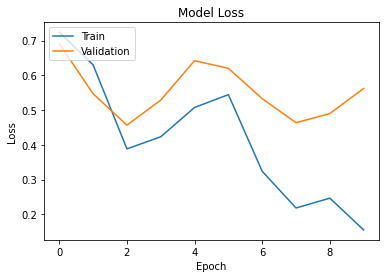

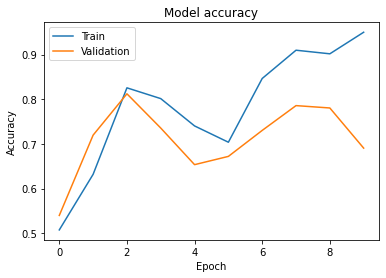

Parameters: learning rate = 0.01, hidden_size = 64, embeded length = 100, epcho = 10, batch_size = 64, fixed_length = 350
The testing accuracy of the final model is 69.04761904761905 %
The testing accuracy of the best model is 81.21693121693121 %


In [102]:
#BEST MODEL FOR RNN
#Trainging parameters
learning_rate = 0.01
hidden_size = 64
BATCH_SIZE = 64
FIX_LEN = 350

# Initialize model, training and testing
TEXT, vocab_size, train_iter, test_iter = load_dataset()
runRamdomSeed() # for reproductivity
rnn_model = RNNModel(output_size, hidden_size, embedding_length)
rnn_model.to(device)
train_loss, train_acc, validation_loss, validation_acc = trainandeval(rnn_model, device, train_iter, test_iter, epochs, learning_rate)
plot_loss(train_loss, validation_loss)
plot_acc(train_acc, validation_acc)
rnn_test_acc = testing1(rnn_model, test_iter, device, learning_rate)
rnn_test_acc1 = testing("RNNModel", test_iter, device, learning_rate, hidden_size)
print(f"Parameters: learning rate = {learning_rate}, hidden_size = {hidden_size}, embeded length = {embedding_length}, epcho = {epochs}, batch_size = {BATCH_SIZE}, fixed_length = {FIX_LEN}")
print("The testing accuracy of the final model is", rnn_test_acc, "%")
print("The testing accuracy of the best model is", rnn_test_acc1, "%")# the model with the lowest loss

Let's look at the accuracy and loss for our best parameters set. In the plot, the validation loss start rising at around epoch 6, which means that there is an overfitting after epoch 6. The accuracy with the final model (with overfitting) is lower than the accuracy of the best model (with the lowest loss, stored as Bestmodel.pth). **For the RNN model, our best model's accuracy is 85.71%**

Epoch: 1 Training Loss:  0.6976761142412822 Valid Loss:  0.6895286639531454
Epoch: 1 Training Accuracy:  0.5212023617820719 Valid Accuracy:  0.5370370370370371
Epoch: 2 Training Loss:  0.6774290561676025 Valid Loss:  0.6906008919080099
Epoch: 2 Training Accuracy:  0.5925925925925926 Valid Accuracy:  0.5396825396825397
Epoch: 3 Training Loss:  0.6497959574063619 Valid Loss:  0.6501843730608622
Epoch: 3 Training Accuracy:  0.6371443907675792 Valid Accuracy:  0.6137566137566137
Epoch: 4 Training Loss:  0.5860287288824717 Valid Loss:  0.5657948851585388
Epoch: 4 Training Accuracy:  0.7058507783145465 Valid Accuracy:  0.6984126984126984
Epoch: 5 Training Loss:  0.44582043985525766 Valid Loss:  0.45822256803512573
Epoch: 5 Training Accuracy:  0.7938808373590982 Valid Accuracy:  0.7962962962962963
Epoch: 6 Training Loss:  0.27568530837694805 Valid Loss:  0.41839223106702167
Epoch: 6 Training Accuracy:  0.8894256575415995 Valid Accuracy:  0.8227513227513228
Epoch: 7 Training Loss:  0.138046077

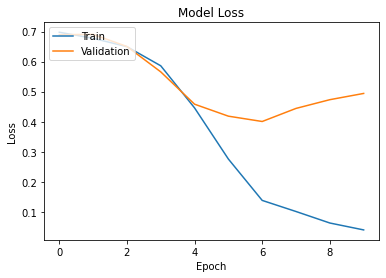

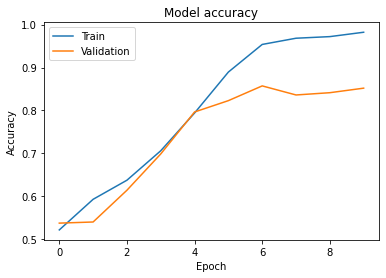

Parameters: learning rate = 0.001, hidden_size = 32, embeded length = 100, epcho = 10, batch_size = 64, fixed_length = 350
The testing accuracy of the final model is 85.18518518518519 %
The testing accuracy of the best model is 85.71428571428571 %


In [92]:
#BEST MODEL FOR RNN
#Trainging parameters
learning_rate = 0.001
hidden_size = 32
BATCH_SIZE = 64
FIX_LEN = 350

# Initialize model, training and testing
TEXT, vocab_size, train_iter, test_iter = load_dataset()
runRamdomSeed() # for reproductivity
rnn_model = RNNModel(output_size, hidden_size, embedding_length)
rnn_model.to(device)
train_loss, train_acc, validation_loss, validation_acc = trainandeval(rnn_model, device, train_iter, test_iter, epochs, learning_rate)
plot_loss(train_loss, validation_loss)
plot_acc(train_acc, validation_acc)
rnn_test_acc = testing1(rnn_model, test_iter, device, learning_rate)
rnn_test_acc1 = testing("RNNModel", test_iter, device, learning_rate, hidden_size)
print(f"Parameters: learning rate = {learning_rate}, hidden_size = {hidden_size}, embeded length = {embedding_length}, epcho = {epochs}, batch_size = {BATCH_SIZE}, fixed_length = {FIX_LEN}")
print("The testing accuracy of the final model is", rnn_test_acc, "%")
print("The testing accuracy of the best model is", rnn_test_acc1, "%")# the model with the lowest loss

## CNN

define the CNN structure

In [106]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(CNNModel, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        embeddings = embeddings.permute(0, 2, 1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        
        outputs = self.fc(encoding)
        return outputs

When trying out the small learning rate 0.00001, the accuracy becomes very low since it lowers the importance of latest batch

Epoch: 1 Training Loss:  0.7194859147071838 Valid Loss:  0.6960646708806356
Epoch: 1 Training Accuracy:  0.4809447128287708 Valid Accuracy:  0.5343915343915344
Epoch: 2 Training Loss:  0.6923771540323893 Valid Loss:  0.6974302132924398
Epoch: 2 Training Accuracy:  0.5222758990874933 Valid Accuracy:  0.5238095238095238
Epoch: 3 Training Loss:  0.6870497186978658 Valid Loss:  0.6945550640424093
Epoch: 3 Training Accuracy:  0.5501878690284487 Valid Accuracy:  0.5238095238095238
Epoch: 4 Training Loss:  0.6832565307617188 Valid Loss:  0.6908387541770935
Epoch: 4 Training Accuracy:  0.559849704777241 Valid Accuracy:  0.5343915343915344
Epoch: 5 Training Loss:  0.6797372539838155 Valid Loss:  0.6886147061983744
Epoch: 5 Training Accuracy:  0.571658615136876 Valid Accuracy:  0.544973544973545
Epoch: 6 Training Loss:  0.6765366752942403 Valid Loss:  0.6870640913645426
Epoch: 6 Training Accuracy:  0.5840042941492217 Valid Accuracy:  0.5343915343915344
Epoch: 7 Training Loss:  0.6735631386439006

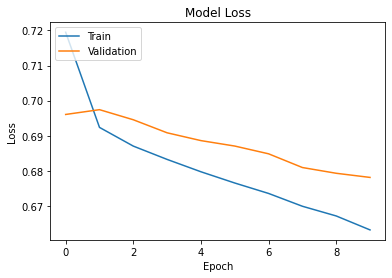

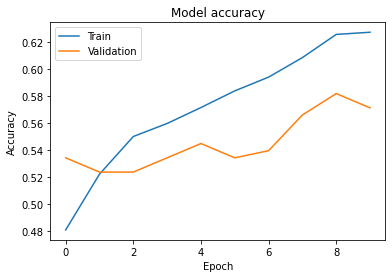

The testing accuracy of the final model is 57.14285714285714 %


In [107]:
# learning rate too small -> low accuracy since it lowers the importance of the latest batch
# Model hyperparameters
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 200, 500]

learning_rate = 0.00001
epochs = 10

# Initialize model, training and testing
runRamdomSeed()
cnn_model = CNNModel(vocab_size, embedding_length, kernel_sizes, nums_channels)
cnn_model.to(device)
cnn_train_loss, cnn_train_acc, cnn_validation_loss, cnn_validation_acc = trainandeval(cnn_model, device, train_iter, test_iter, epochs, learning_rate)
plot_loss(cnn_train_loss, cnn_validation_loss)
plot_acc(cnn_train_acc, cnn_validation_acc)
cnn_test_acc = testing1(cnn_model, test_iter, device, learning_rate)
print ("The testing accuracy of the final model is", cnn_test_acc, "%")

**For the CNN model, our best model's accuracy is 84.92%**

Epoch: 1 Training Loss:  0.8658986886342367 Valid Loss:  0.5807672540346781
Epoch: 1 Training Accuracy:  0.487385936661299 Valid Accuracy:  0.783068783068783
Epoch: 2 Training Loss:  0.519497299194336 Valid Loss:  0.49343643585840863
Epoch: 2 Training Accuracy:  0.7750939345142244 Valid Accuracy:  0.8597883597883598
Epoch: 3 Training Loss:  0.37974311312039694 Valid Loss:  0.43163520097732544
Epoch: 3 Training Accuracy:  0.998389694041868 Valid Accuracy:  0.8544973544973545
Epoch: 4 Training Loss:  0.2939806600411733 Valid Loss:  0.39382049441337585
Epoch: 4 Training Accuracy:  0.9994632313472893 Valid Accuracy:  0.8518518518518519
Epoch: 5 Training Loss:  0.22978292206923168 Valid Loss:  0.358792503674825
Epoch: 5 Training Accuracy:  1.0 Valid Accuracy:  0.828042328042328
Epoch: 6 Training Loss:  0.17565977176030476 Valid Loss:  0.31937448183695477
Epoch: 6 Training Accuracy:  1.0 Valid Accuracy:  0.8518518518518519
Epoch: 7 Training Loss:  0.13134154975414275 Valid Loss:  0.306068867

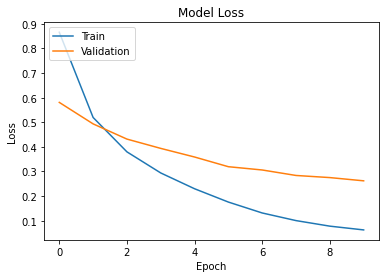

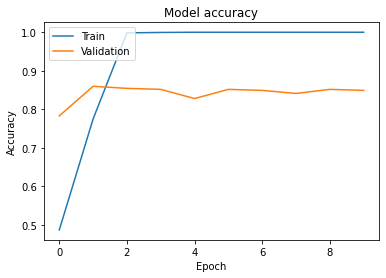

The testing accuracy of the final model is 84.92063492063492 %


In [108]:
# the perfect one
# Model hyperparameters
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 200, 500]

learning_rate = 0.001
epochs = 10

# Initialize model, training and testing
runRamdomSeed()
cnn_model = CNNModel(vocab_size, embedding_length, kernel_sizes, nums_channels)
cnn_model.to(device)
cnn_train_loss, cnn_train_acc, cnn_validation_loss, cnn_validation_acc = trainandeval(cnn_model, device, train_iter, test_iter, epochs, learning_rate)
plot_loss(cnn_train_loss, cnn_validation_loss)
plot_acc(cnn_train_acc, cnn_validation_acc)
cnn_test_acc = testing1(cnn_model, test_iter, device, learning_rate)
print ("The testing accuracy of the final model is", cnn_test_acc, "%")

# Model Performance

In our project, we have tried out differnt models, and their accuracy are as follows:

Part one : Machine Learning

1.   TF-IDF Vectorizer + Randomforest Classifier (TFIDF+RF) : 0.8571
2.   Countvectorizer + Randomforest Classifier (CV+RF) : 0.8492
3.   TF-IDF Vectorizer + Naived Based Classifier (TFIDF+NB): 0.8518
4.   Countvectorizer + Naived Based Classifier (CV+NB): 0.8412

Part two: Neural Network


1.   RNN: 0.8571
2.   CNN: 0.8492


Accuracy from high to low : TFIDF+RF = RNN > TFIDF+NB > CNN= CV+RF > CV+NB

**The higest accuracy is 85.71%**






